<a href="https://colab.research.google.com/github/JirayuL/wild_salmon_analysis/blob/main/The_decrease_of_wild_salmon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# STEP 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from statsmodels.tsa.api import ExponentialSmoothing

# STEP 2: Upload Wild CSV File
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(filename)

Saving SalmonandSeaTroutNets1952-2022.csv to SalmonandSeaTroutNets1952-2022 (1).csv


In [21]:
# STEP 2: Upload Farm CSV File
uploaded = files.upload()
filename = next(iter(uploaded))
farm_df = pd.read_csv(filename)

Saving Scottish Fish Farm Production Survey T24 - Atlantic salmon - Annual production of Atlantic salmon 1979-_0.csv to Scottish Fish Farm Production Survey T24 - Atlantic salmon - Annual production of Atlantic salmon 1979-_0 (1).csv


In [22]:
# STEP 3: Prepare & Clean Data
df = df.dropna(subset=['Year', 'Netting effort'])
df['Year'] = df['Year'].astype(int)
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
df['Wild Total weight'] = df['Wild MSW weight (kg)'].fillna(0) + df['Wild 1SW weight (kg)'].fillna(0)

# STEP 4: Aggregate Data by Year
agg_df = df.groupby('Year').agg({
    'Wild Total': 'sum',
    'Wild Total weight': 'sum',
    'Netting effort': 'sum'
}).reset_index()

# Catch Per Unit Effort
agg_df['CPUE'] = agg_df['Wild Total'] / agg_df['Netting effort']


/tmp/ipython-input-22-3842876237.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-22-3842876237.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-22-3842876237.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
# Forecast Wild Salmon Count (next 5 years)
ts = agg_df.set_index('Year')['Wild Total'].sort_index()
model = ExponentialSmoothing(ts, trend='add', seasonal=None).fit()
forecast = model.forecast(5).clip(lower=0)
forecast_years = list(range(ts.index[-1] + 1, ts.index[-1] + 6))

# Trendline for Count
z = np.polyfit(ts.index, ts.values, 1)
p = np.poly1d(z)
trendline = p(ts.index)

# Forecast Wild Salmon Weight (next 5 years)
ts_weight = agg_df.set_index('Year')['Wild Total weight'].sort_index()
weight_model = ExponentialSmoothing(ts_weight, trend='add', seasonal=None).fit()
weight_forecast = weight_model.forecast(5).clip(lower=0)
weight_forecast_years = list(range(ts_weight.index[-1] + 1, ts_weight.index[-1] + 6))

# Trendline for Weight
z_w = np.polyfit(ts_weight.index, ts_weight.values, 1)
p_w = np.poly1d(z_w)
weight_trendline = p_w(ts_weight.index)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/b

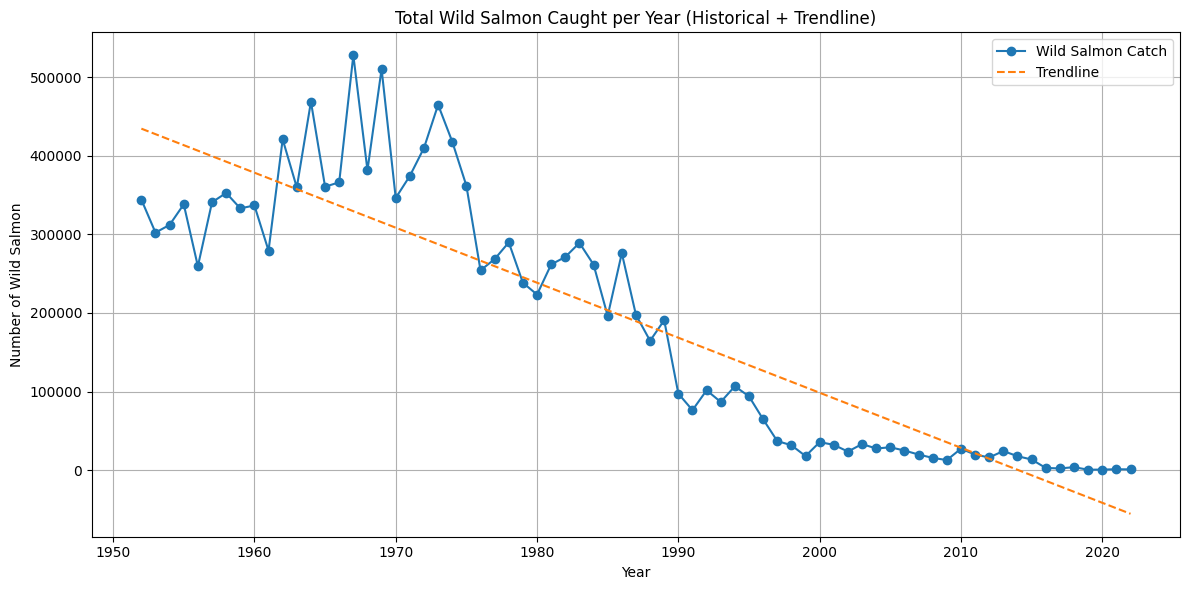

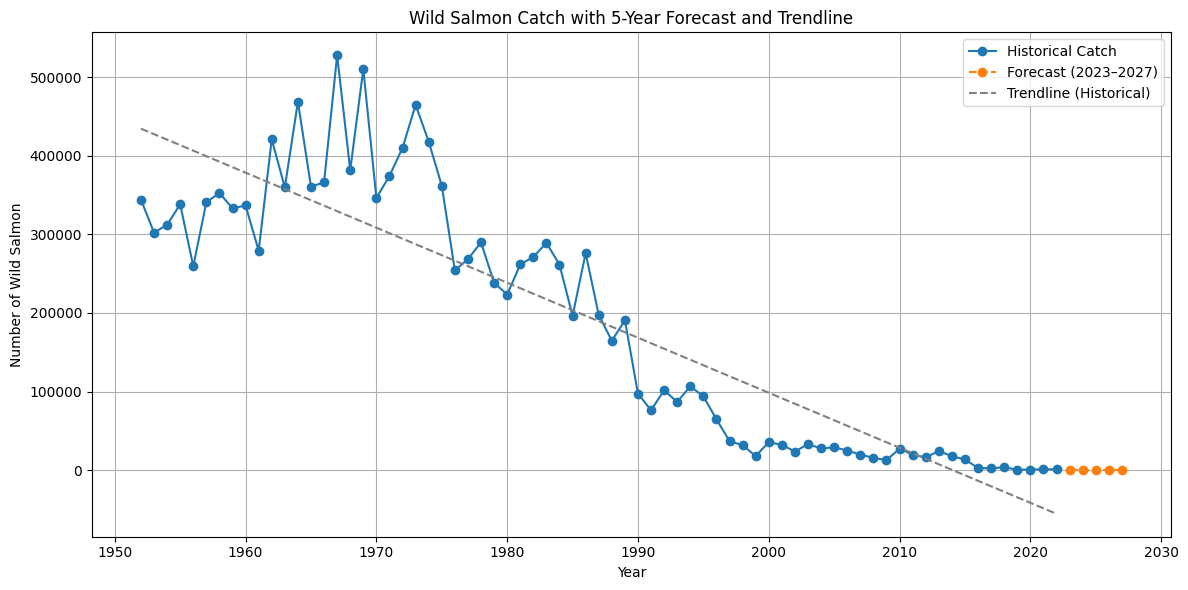

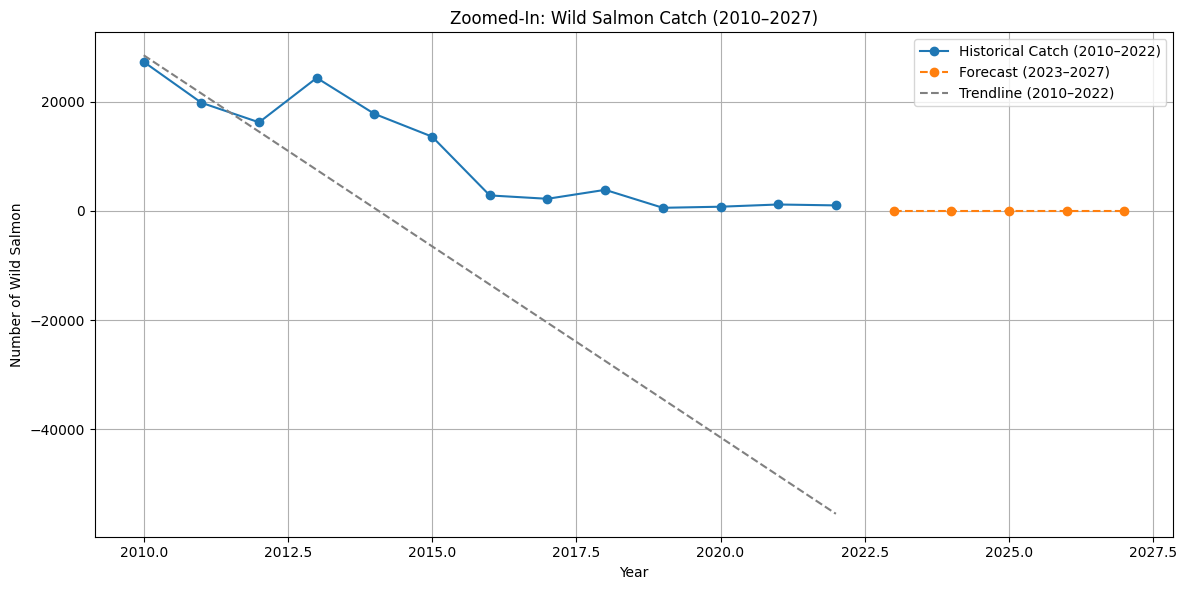

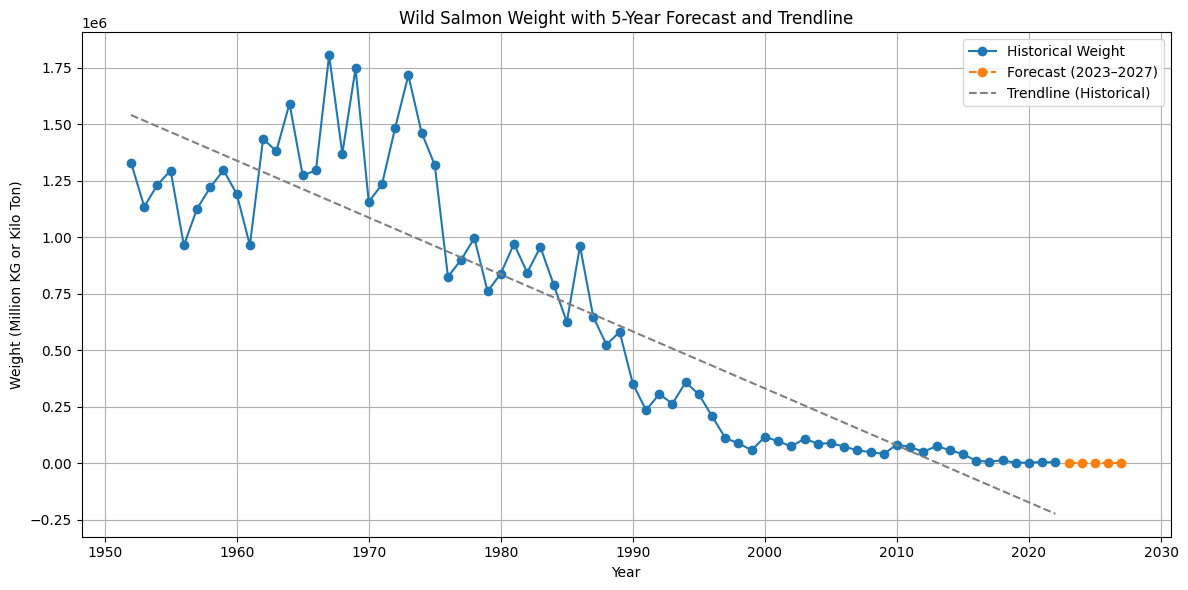

In [24]:
# Chart 1: Historical Wild Salmon Catch + Trendline
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, marker='o', label='Wild Salmon Catch')
plt.plot(ts.index, trendline, linestyle='--', label='Trendline')
plt.title('Total Wild Salmon Caught per Year (Historical + Trendline)')
plt.xlabel('Year')
plt.ylabel('Number of Wild Salmon')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Chart 2: Historical + Forecasted Wild Salmon Catch + Trendline
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, marker='o', label='Historical Catch')
plt.plot(forecast_years, forecast.values, marker='o', linestyle='--', label='Forecast (2023–2027)')
plt.plot(ts.index, trendline, linestyle='--', color='gray', label='Trendline (Historical)')
plt.title('Wild Salmon Catch with 5-Year Forecast and Trendline')
plt.xlabel('Year')
plt.ylabel('Number of Wild Salmon')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Chart 3: Zoom-In (2010 to Present)
ts_recent = ts[ts.index >= 2010]
trendline_recent = p(ts_recent.index)
plt.figure(figsize=(12, 6))
plt.plot(ts_recent.index, ts_recent.values, marker='o', label='Historical Catch (2010–2022)')
plt.plot(forecast_years, forecast.values, marker='o', linestyle='--', label='Forecast (2023–2027)')
plt.plot(ts_recent.index, trendline_recent, linestyle='--', color='gray', label='Trendline (2010–2022)')
plt.title('Zoomed-In: Wild Salmon Catch (2010–2027)')
plt.xlabel('Year')
plt.ylabel('Number of Wild Salmon')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Chart 4: Wild Salmon Weight (Historical + Forecast + Trendline)
plt.figure(figsize=(12, 6))
plt.plot(ts_weight.index, ts_weight.values, marker='o', label='Historical Weight')
plt.plot(weight_forecast_years, weight_forecast.values, marker='o', linestyle='--', label='Forecast (2023–2027)')
plt.plot(ts_weight.index, weight_trendline, linestyle='--', color='gray', label='Trendline (Historical)')
plt.title('Wild Salmon Weight with 5-Year Forecast and Trendline')
plt.xlabel('Year')
plt.ylabel('Weight (Million KG or Kilo Ton)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


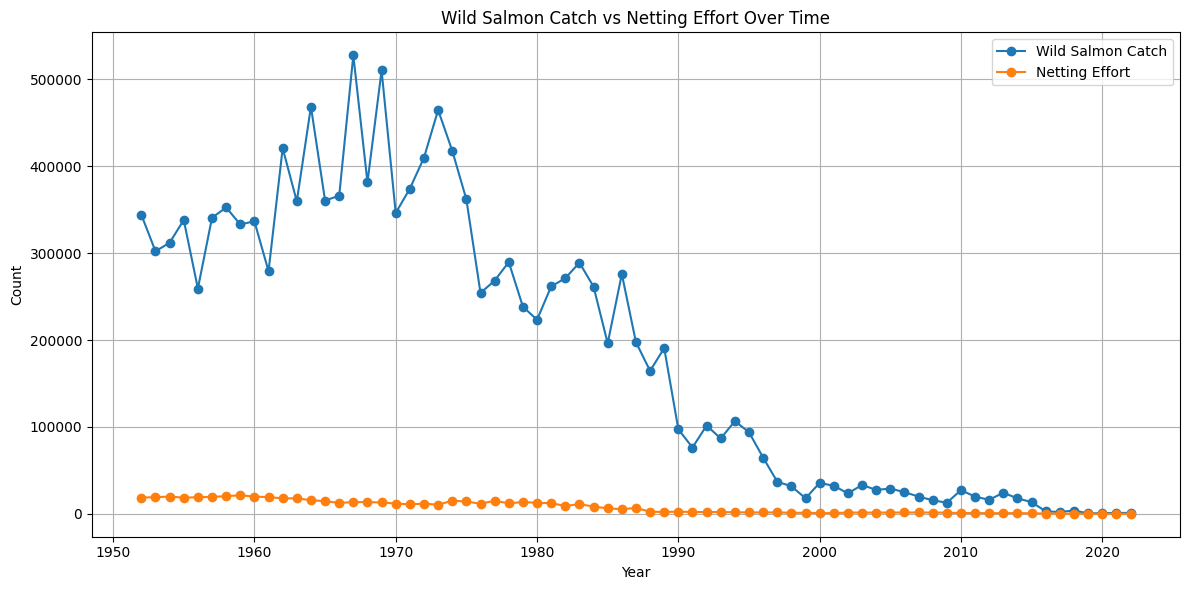

In [25]:
# ✅ STEP 7: Wild Salmon Catch vs Netting Effort
plt.figure(figsize=(12, 6))
plt.plot(agg_df['Year'], agg_df['Wild Total'], label='Wild Salmon Catch', marker='o')
plt.plot(agg_df['Year'], agg_df['Netting effort'], label='Netting Effort', marker='o')
plt.title('Wild Salmon Catch vs Netting Effort Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

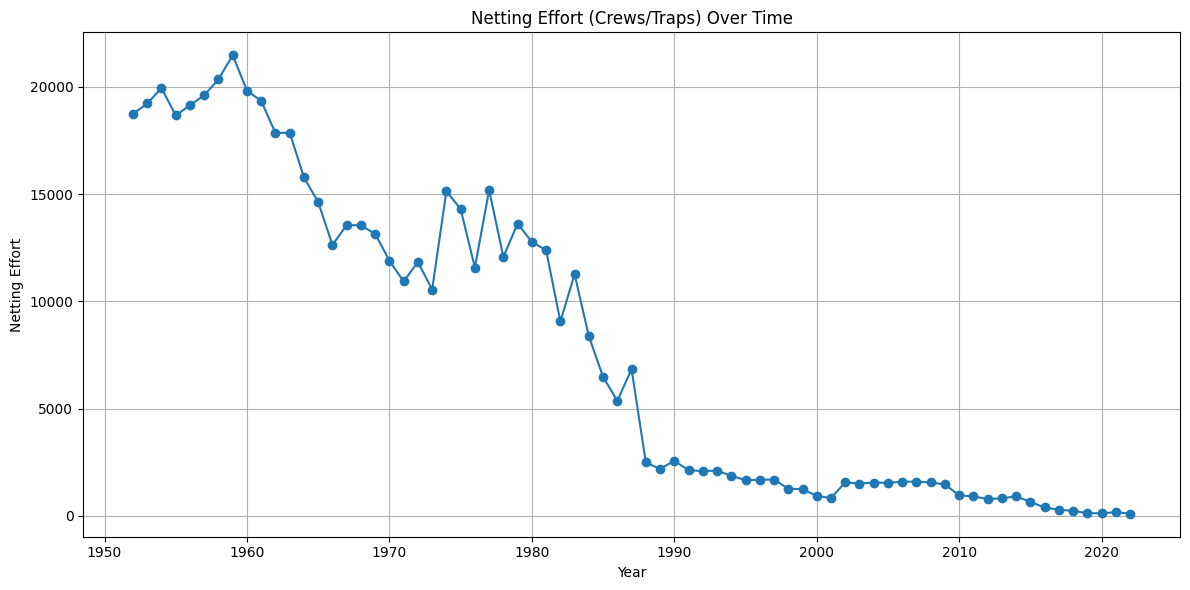

In [26]:
# ✅ STEP 8: Netting Effort Over Time (Separate Chart)
plt.figure(figsize=(12, 6))
plt.plot(agg_df['Year'], agg_df['Netting effort'], marker='o', label='Netting Effort')
plt.title('Netting Effort (Crews/Traps) Over Time')
plt.xlabel('Year')
plt.ylabel('Netting Effort')
plt.grid(True)
plt.tight_layout()
plt.show()


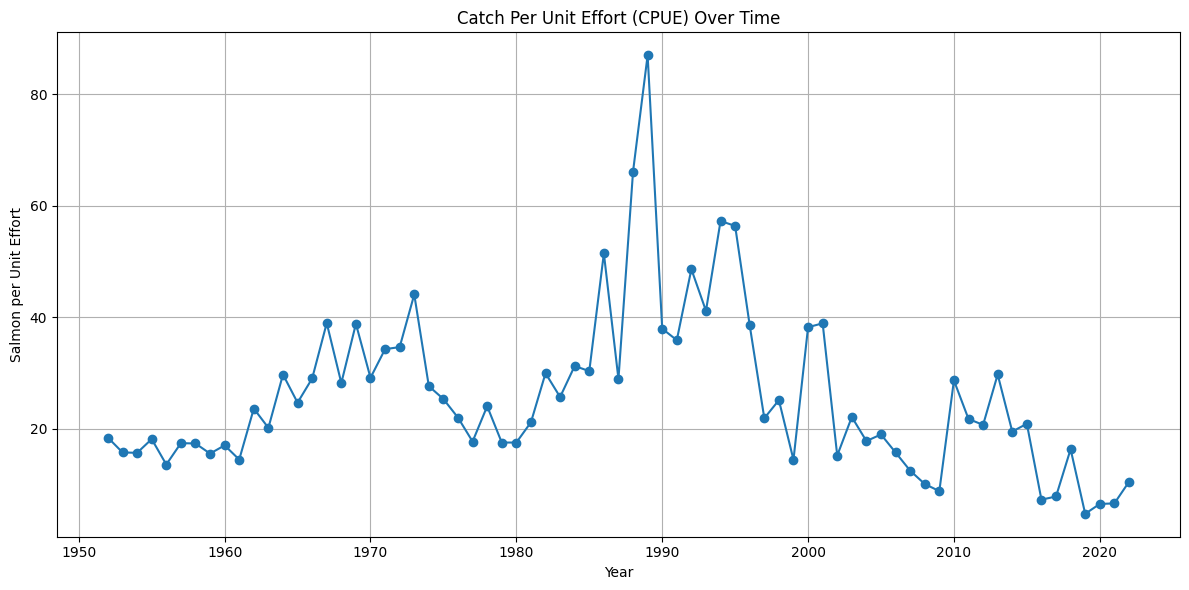

In [27]:
# ✅ STEP 9: CPUE Over Time
plt.figure(figsize=(12, 6))
plt.plot(agg_df['Year'], agg_df['CPUE'], label='CPUE (Wild per Crew/Trap)', marker='o')
plt.title('Catch Per Unit Effort (CPUE) Over Time')
plt.xlabel('Year')
plt.ylabel('Salmon per Unit Effort')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# ✅ STEP 1: Install Plotly if needed
!pip install plotly --quiet

# ✅ STEP 2: Import Libraries
import pandas as pd
import plotly.express as px

# ✅ STEP 3: Aggregate Catch by Region
region_df = df.copy()
region_df['Wild Total'] = region_df['Wild MSW number'].fillna(0) + region_df['Wild 1SW number'].fillna(0)
region_summary = region_df.groupby('Region')['Wild Total'].sum().reset_index()

# ✅ STEP 4: Add Latitude/Longitude (Example Estimates for Scottish Salmon Regions)
region_coords = {
    'Clyde Coast':      {'lat': 55.9, 'lon': -4.9},
    'East':             {'lat': 56.0, 'lon': -2.8},
    'Moray Firth':      {'lat': 57.7, 'lon': -3.5},
    'North':            {'lat': 58.3, 'lon': -4.3},
    'North East':       {'lat': 57.1, 'lon': -2.2},
    'North West':       {'lat': 58.0, 'lon': -5.3},
    'Orkney':           {'lat': 59.0, 'lon': -3.0},
    'Outer Hebrides':   {'lat': 57.8, 'lon': -6.2},
    'Solway':           {'lat': 54.9, 'lon': -3.6},
    'West Coast':       {'lat': 56.8, 'lon': -5.5}
}

# Merge coordinates into the summary dataframe
region_summary['lat'] = region_summary['Region'].map(lambda x: region_coords.get(x, {}).get('lat'))
region_summary['lon'] = region_summary['Region'].map(lambda x: region_coords.get(x, {}).get('lon'))

# ✅ STEP 5: Filter out missing coords (just in case)
region_summary = region_summary.dropna(subset=['lat', 'lon'])

# ✅ STEP 6: Plot Geo Chart using Plotly
fig = px.scatter_geo(
    region_summary,
    lat='lat',
    lon='lon',
    text='Region',
    size='Wild Total',
    color='Wild Total',
    color_continuous_scale='Blues',
    title='Total Wild Salmon Catch by Region (1952–2022)',
    projection='natural earth',
)

fig.update_layout(
    geo=dict(
        projection_type="natural earth",
        center={"lat": 56.5, "lon": -4},  # Centered on Scotland
        lonaxis_range=[-8, 2],            # Longitude bounds for UK
        lataxis_range=[54, 61],           # Latitude bounds for Scotland
        showland=True,
        landcolor="lightgrey",
    )
)
fig.show()


In [29]:
# ✅ Make sure Plotly is installed
!pip install plotly --quiet

# ✅ Import libraries
import pandas as pd
import plotly.express as px

# ✅ Region coordinates (centered on Scotland)
region_coords = {
    'Clyde Coast':      {'lat': 55.9, 'lon': -4.9},
    'East':             {'lat': 56.0, 'lon': -2.8},
    'Moray Firth':      {'lat': 57.7, 'lon': -3.5},
    'North':            {'lat': 58.3, 'lon': -4.3},
    'North East':       {'lat': 57.1, 'lon': -2.2},
    'North West':       {'lat': 58.0, 'lon': -5.3},
    'Orkney':           {'lat': 59.0, 'lon': -3.0},
    'Outer Hebrides':   {'lat': 57.8, 'lon': -6.2},
    'Solway':           {'lat': 54.9, 'lon': -3.6},
    'West Coast':       {'lat': 56.8, 'lon': -5.5}
}

# ✅ Aggregate Wild Total by Region
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
region_summary = df.groupby('Region')['Wild Total'].sum().reset_index()

# ✅ Add coordinates
region_summary['lat'] = region_summary['Region'].map(lambda x: region_coords.get(x, {}).get('lat'))
region_summary['lon'] = region_summary['Region'].map(lambda x: region_coords.get(x, {}).get('lon'))
region_summary = region_summary.dropna(subset=['lat', 'lon'])

# ✅ Build Map with Better Dot Visibility
fig = px.scatter_mapbox(
    region_summary,
    lat='lat',
    lon='lon',
    text='Region',
    hover_name='Region',
    size='Wild Total',
    color='Wild Total',
    size_max=50,                       # Increased max size
    color_continuous_scale='YlGnBu',
    opacity=0.85,                      # More visible over basemap
    zoom=5,
    height=600,
    title='Total Wild Salmon Catch by Region (with Enhanced Visibility)'
)

# Use open-access map style (no token required)
fig.update_layout(
    mapbox_style='open-street-map',
    mapbox_center={"lat": 57.2, "lon": -4},
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()


In [30]:
# Convert farm tonnes to kg
farm_df['Farm Weight (kg)'] = farm_df['Tonnes'] * 1000

# Align both datasets
farm_weight_series = farm_df.set_index('Year')['Farm Weight (kg)']
common_years = ts_weight.index.intersection(farm_weight_series.index)
aligned_farm_weight = farm_weight_series.loc[common_years]

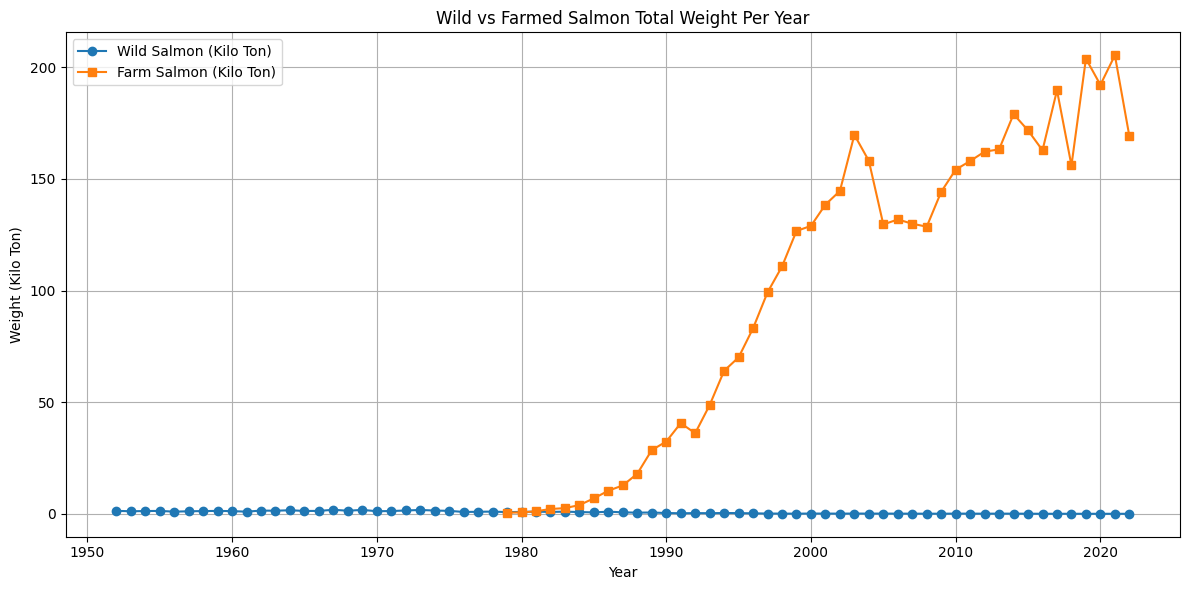

In [31]:
# Plot Wild vs Farm Total Weight Per Year
plt.figure(figsize=(12, 6))
plt.plot(ts_weight.index, ts_weight.values / 1000000 , marker='o', label='Wild Salmon (Kilo Ton)')
plt.plot(aligned_farm_weight.index, aligned_farm_weight.values / 1000000, marker='s', linestyle='-', label='Farm Salmon (Kilo Ton)')

plt.title('Wild vs Farmed Salmon Total Weight Per Year')
plt.xlabel('Year')
plt.ylabel('Weight (Kilo Ton)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Clustering

In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [33]:
# Clean necessary columns
df = df.dropna(subset=['Year', 'Region'])
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
df['Wild Weight'] = df['Wild MSW weight (kg)'].fillna(0) + df['Wild 1SW weight (kg)'].fillna(0)
df['CPUE'] = df['Wild Total'] / df['Netting effort'].replace(0, np.nan)

# Aggregate by Region
region_df = df.groupby('Region').agg({
    'Wild Total': 'mean',
    'Wild Weight': 'mean',
    'Netting effort': 'mean',
    'CPUE': 'mean'
}).dropna().reset_index()

In [34]:
# Select features to cluster
features = ['Wild Total', 'Wild Weight', 'Netting effort', 'CPUE']
X = region_df[features]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans (try 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
region_df['Cluster'] = kmeans.fit_predict(X_scaled)

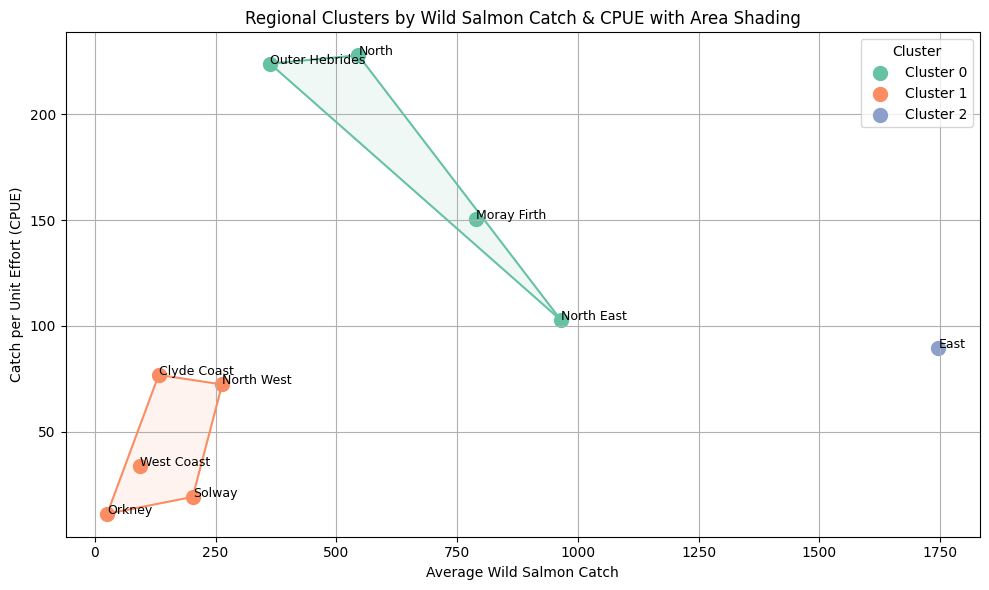

,Region,Wild Total,Wild Weight,Netting effort,CPUE,Cluster
3,North,545.539723,1707.032762,4.869534,227.963838,0
2,Moray Firth,789.342995,2672.365604,12.163285,150.459027,0
7,Outer Hebrides,362.777358,1076.675472,1.422642,223.998413,0
4,North East,965.641225,3313.860633,18.572684,102.531667,0
5,North West,263.585824,802.285326,3.636398,72.279013,1
0,Clyde Coast,132.357347,431.400573,2.670086,76.801630,1
6,Orkney,25.666667,83.633333,2.166667,11.111111,1
8,Solway,202.686599,682.976935,103.487587,19.097921,1
9,West Coast,93.427384,298.018362,2.077364,33.893276,1
1,East,1746.561378,6772.815284,12.159874,89.322691,2


In [35]:
from scipy.spatial import ConvexHull

# Create plot
plt.figure(figsize=(10, 6))
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# Plot each cluster with convex hull
for cluster in sorted(region_df['Cluster'].unique()):
    cluster_data = region_df[region_df['Cluster'] == cluster]
    x = cluster_data['Wild Total'].values
    y = cluster_data['CPUE'].values

    # Scatter points
    plt.scatter(x, y, s=100, label=f'Cluster {cluster}', color=colors[cluster])

    # Plot convex hull (if enough points)
    if len(cluster_data) >= 3:
        points = np.column_stack((x, y))
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], color=colors[cluster])
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], alpha=0.1, color=colors[cluster])

    # Label regions
    for _, row in cluster_data.iterrows():
        plt.text(row['Wild Total'], row['CPUE'], row['Region'], fontsize=9)

# Plot formatting
plt.title('Regional Clusters by Wild Salmon Catch & CPUE with Area Shading')
plt.xlabel('Average Wild Salmon Catch')
plt.ylabel('Catch per Unit Effort (CPUE)')
plt.grid(True)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# View cluster assignment
region_df.sort_values(by='Cluster')

# Seasonal Salmon Catch by Month

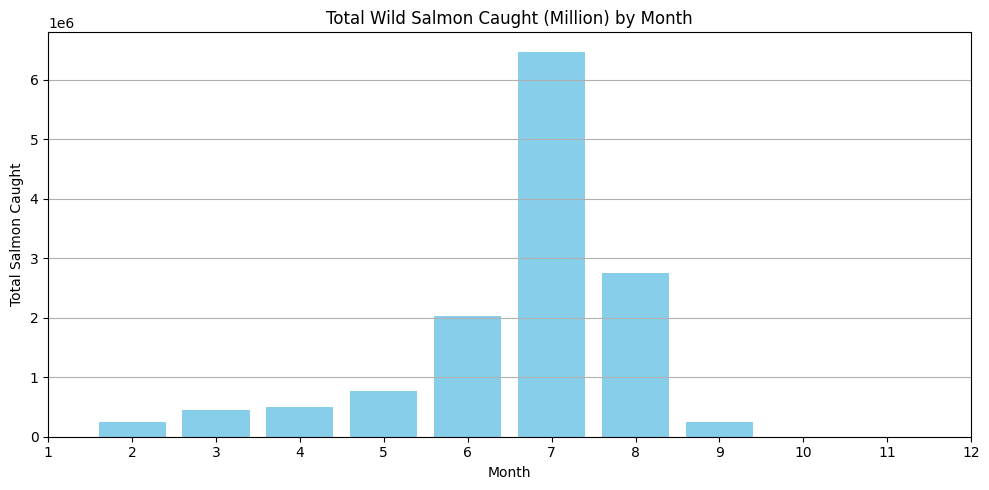

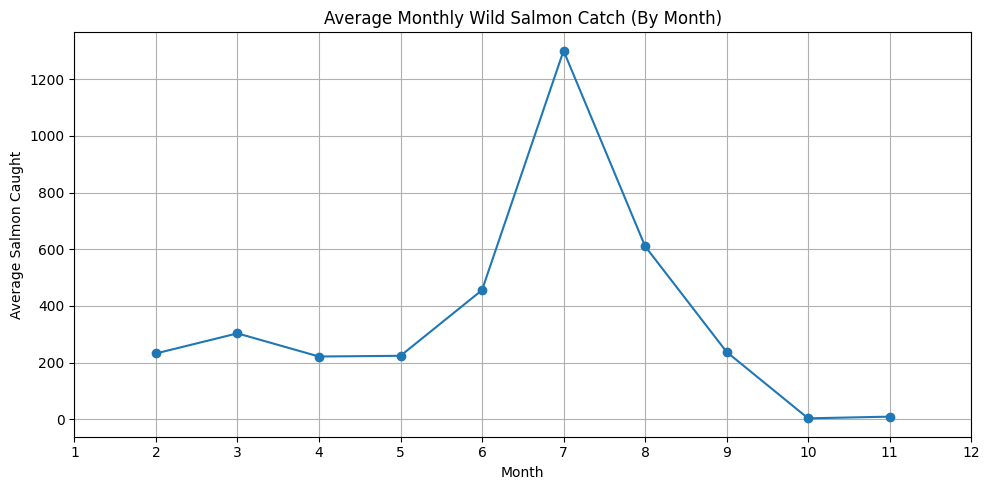

In [37]:
# Prepare relevant columns
df['Month number'] = pd.to_numeric(df['Month number'], errors='coerce')
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)

# Group by month
monthly_catch = df.groupby('Month number')['Wild Total'].agg(['sum', 'mean']).reset_index()
monthly_catch = monthly_catch.sort_values('Month number')

# Plot Total Catch per Month
plt.figure(figsize=(10, 5))
plt.bar(monthly_catch['Month number'], monthly_catch['sum'], color='skyblue')
plt.title('Total Wild Salmon Caught (Million) by Month')
plt.xlabel('Month')
plt.ylabel('Total Salmon Caught')
plt.xticks(range(1, 13))
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot Average Catch per Month
plt.figure(figsize=(10, 5))
plt.plot(monthly_catch['Month number'], monthly_catch['mean'], marker='o')
plt.title('Average Monthly Wild Salmon Catch (By Month)')
plt.xlabel('Month')
plt.ylabel('Average Salmon Caught')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

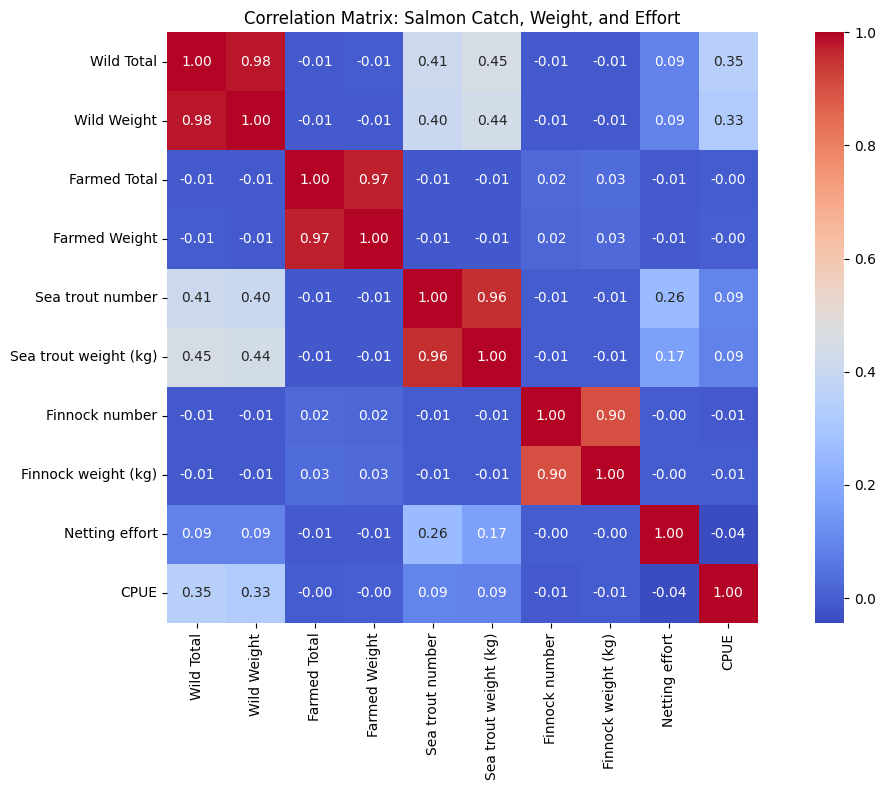

In [38]:
# Compute additional useful fields
df['Wild Total'] = df['Wild MSW number'].fillna(0) + df['Wild 1SW number'].fillna(0)
df['Wild Weight'] = df['Wild MSW weight (kg)'].fillna(0) + df['Wild 1SW weight (kg)'].fillna(0)
df['Farmed Total'] = df['Farmed MSW number'].fillna(0) + df['Farmed 1SW number'].fillna(0)
df['Farmed Weight'] = df['Farmed MSW weight (kg)'].fillna(0) + df['Farmed 1SW weight (kg)'].fillna(0)
df['CPUE'] = df['Wild Total'] / df['Netting effort'].replace(0, np.nan)

# Select numeric variables for correlation
numeric_cols = [
    'Wild Total', 'Wild Weight',
    'Farmed Total', 'Farmed Weight',
    'Sea trout number', 'Sea trout weight (kg)',
    'Finnock number', 'Finnock weight (kg)',
    'Netting effort', 'CPUE'
]

# Drop rows with missing values in selected columns
corr_df = df[numeric_cols].dropna()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix: Salmon Catch, Weight, and Effort")
plt.tight_layout()
plt.show()